In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

1단계. 시계열 자료를 시각화 해서 안정적 시계열인지를 확인한다. Visualize the time series

2단계. 시계열 자료를 안정적 시계열로 변환한다. Stationarize the series

3단계. ACF/PACF차트나 auto.arima 함수를 사용하여 최적화된 파라미터를 찾는다. 
Plot ACF/PACF charts and find optimal parameters

4단계. ARIMA 모형을 만든다. Build the ARIMA model

5단계. (필요한 경우) 미래 추이에 대해 예측한다. Make prediction

## 1. 시계열 데이터의 정상성과 이분산성을 분석하기 위해 시각화하고 설명

= 시계열 데이터의 정상성/비정상성을 그래프로 확인하라

- 정규성(정상성): 잔차가 정규분포를 따름을 의미  
정상성(stationarity)을 나타내는 시계열은 시계열의 특징(평균, 분산, 표준편차 등)이 해당 시계열이 관측된 시간에 무관


- 이분산성 : 독립 변수 값의 크기가 커지면 종속 변수 값의 분산도 커지거나 작아짐

In [2]:
df = pd.read_csv('Data/07. portland-oregon-average-monthly-.csv', parse_dates=['Month'])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 2 columns):
 #   Column                                                                                      Non-Null Count  Dtype         
---  ------                                                                                      --------------  -----         
 0   Month                                                                                       114 non-null    datetime64[ns]
 1   Portland Oregon average monthly bus ridership (/100) January 1973 through June 1982, n=114  114 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.9 KB


In [4]:
df.columns =['Month','ridership']

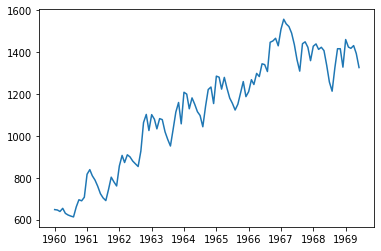

In [5]:
plt.plot(df.Month, df.ridership)

- 비정상성 데이터로 주기성과 추세성을 띄는 것으로 보임. ADF(Augmented Dickey-Fuller) test 확인 필요

In [6]:
from statsmodels.tsa.stattools import adfuller
def ad_test(dataset):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:",      dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)
        
ad_test(df.ridership)

1. ADF :  -1.5365971444531585
2. P-Value :  0.5153358797821741
3. Num Of Lags :  12
4. Num Of Observations Used For ADF Regression: 101
5. Critical Values :
	 1% :  -3.4968181663902103
	 5% :  -2.8906107514600103
	 10% :  -2.5822770483285953


: p> 0.05 이므로 특정 추세 (다양한 평균) 또는 계절성이 있음을 나타낼 수 있음

In [7]:
## 시간 독립변수의 변형

import datetime as dt

#df['Ordinal'] = df.Month.map(dt.datetime.toordinal)
#df['timestamp'] = df.Month.map(dt.datetime.timestamp)
#df['Year'] = df.Month.dt.year
#df['Month'] = df.Month.dt.Month
#df['day'] = df.Month.dt.day


In [8]:
import statsmodels.api as sm

ols=sm.OLS(df.ridership, df.index).fit()
print(ols.params)
ols.summary()

x1    16.752434
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              ridership   R-squared (uncentered):                   0.903
Model:                            OLS   Adj. R-squared (uncentered):              0.902
Method:                 Least Squares   F-statistic:                              1055.
Date:                Sat, 13 Feb 2021   Prob (F-statistic):                    3.91e-59
Time:                        01:24:10   Log-Likelihood:                         -832.31
No. Observations:                 114   AIC:                                      1667.
Df Residuals:                     113   BIC:                                      1669.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            16.7524      0.516     32.475      0.000      15.730      17.774
==============================================================================
Omnibus:                        9.381   Durbin-Watson:                   0.026
Prob(Omnibus):                  0.009   Jarque-Bera (JB):                8.123
Skew:                          -0.569   Prob(JB):                       0.0172
Kurtosis:                       2.355   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

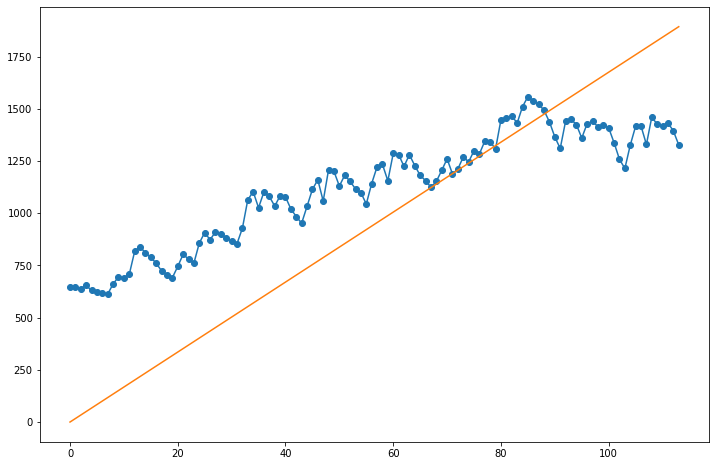

In [9]:
t=df.index
y=df.ridership
trend=ols.params[0]*t

plt.figure(figsize=(12,8))
plt.plot(t, y, 'o-', t, trend, '-')

1. QQ plot을 통해 정규성 검정

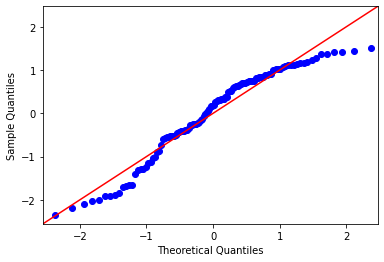

In [10]:
res = ols.resid
fig = sm.qqplot(res, fit=True, line='45')

- 정규성을 띄지 않음

2. 독립변수와 잔차와의 관계를 통해 이분산성 확인

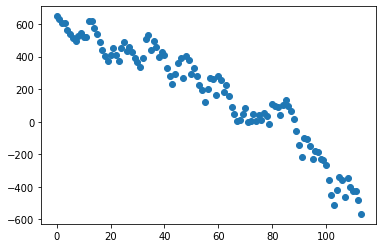

In [11]:
plt.scatter(df.index, res)

- 독립변수가 커짐에 따라 잔차값이 감소하는 경향을 띔. 이분산성 문제 발생

## 2.  시계열 데이터가 정규성이 아니라면, 고정 시계열이 있는지 확인하고 이를 처리 
= 비정상성을 띄는 시계열 데이터를 정상성을 띄도록 변형하라  
= 시계열 자료의 계절성이 시간이 지남에 따라 고정(fixed)되어 있는지 아니면 확산(increasing)되는 지 확인 


- 시계열 데이터 패턴 종류

    1. 추세-주기 성분 
    2. 계절성 성분
    3. (시계열의 나머지 요소를 포함하는) 나머지(remainder) 성분  
    
    
- 시계열 분석 모델 종류
    
    1. AR(autoregressive models) : 목표 예상 변수(forecast variable)의 과거 값을 이용, 보통은 자기회귀 모델을 정상성을 나타내는 데이터에만 사용
    2. MA(Moving-Average) : 과거 예측 오차(forecast error)을 이용
    3. ARIMA(AR+MA)
    4. SARIMA : 비정상적 시계열 자료인데다가 계절효과도 추가되면 계절성이 존재하는 비정상적 시계열이기 때문에 계절 ARIMA모형을 이용한다. 계절 ARIMA모형은 순수 계절시계열이나 비정상적인 시계열과는 다른 패턴을 갖고 있는 시계열 자료이다. 따라서 계절성과 비정상성을 동시에 고려해야 한다. 계절효과를 제거한 뒤 분산안정을 위한 자료변환과 추세제거를 위한 차분을 적용하면 정상시계열 자료를 얻을 수 있다.
    
    
- AR 및 MA 모델 모수 추정법

    1. ACF(Autocorrelation function) : Lag에 따른 관측치들 사이의 관련성을 측정하는 함수
    2. PACF(Partial autocorrelation function): k 이외의 모든 다른 시점 관측치의 영향력을 배제하고 두 관측치의 관련성을 측정하는 함수
    
    시계열 데이터가 AR의 특성을 띄는 경우, ACF는 천천히 감소하고 PACF는 처음 시차를 제외하고 급격히 감소한다.
반대로, MA의 특성을 띄는 경우 ACF는 급격히 감소하고 PACF는 천천히 감소한다.
급격히 감소하는 시차를 각 AR과 MA 모형의 모수(p, q)로 사용할 수 있다. 또한 데이터를 차분하여 ACF 및 PACF 계산함으로써 적절한 차분횟수까지 구할 수 있다

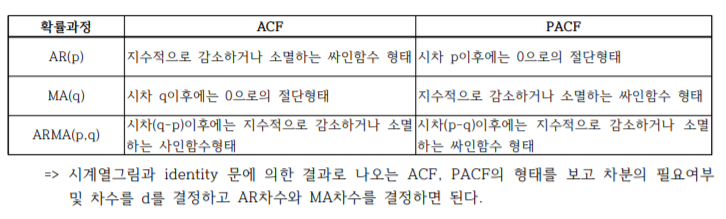


In [12]:
df.set_index('Month', inplace=True)

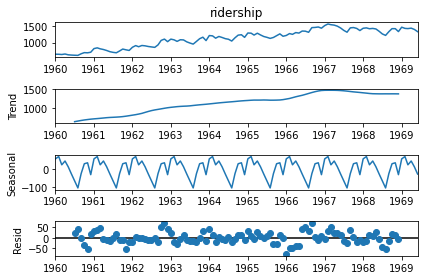

In [13]:
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df.ridership, freq=12)
decomposition.plot()
plt.show()

In [14]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

- 1년마다(freq=12) 계절성 및 추세성 성분 확인 => SARIMA 모델 사용 필요

## 3. SARIMA 분석을 실시, 여러 파라미터를 적용해보고 가장 성능이 좋은 것을 제시

(1) ARIMA 모델 p,d,q값 결정 

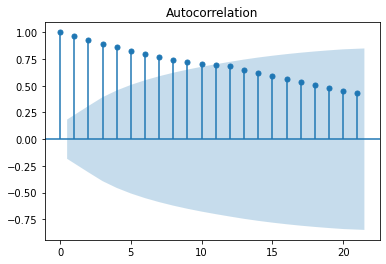

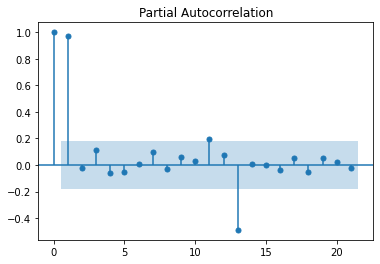

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df.ridership)
plot_pacf(df.ridership)
plt.show()

<AxesSubplot:xlabel='Month'>

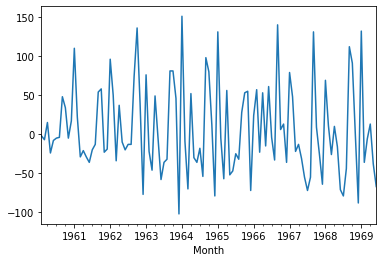

In [16]:
diff_1 = df.ridership.diff(periods=1).iloc[1:]
diff_1.plot()

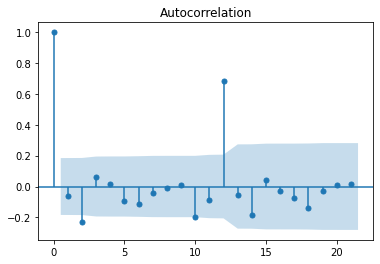

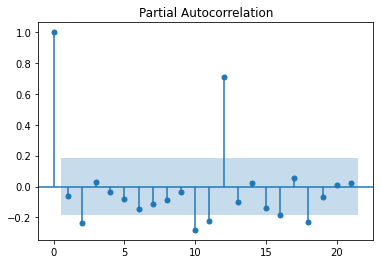

In [17]:
plot_acf(diff_1)
plot_pacf(diff_1)
plt.show()

- 1차 차분 시 자기상관 특성 사라짐

(2) 계절성 성분 p, d, q값 결정

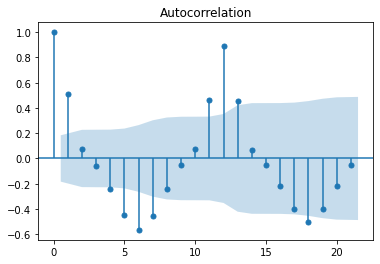

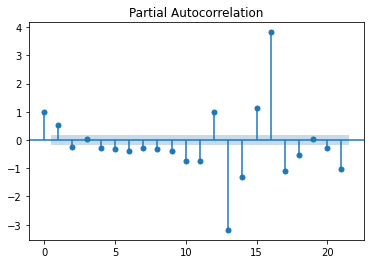

In [18]:
plot_acf(seasonal)
plot_pacf(seasonal)
plt.show()

<AxesSubplot:xlabel='Month'>

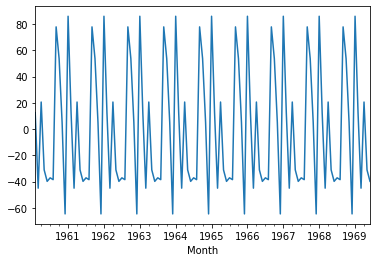

In [19]:
season_diff_1 = seasonal.diff(periods=1).iloc[1:]
season_diff_1.plot()

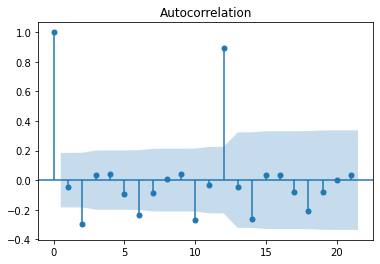

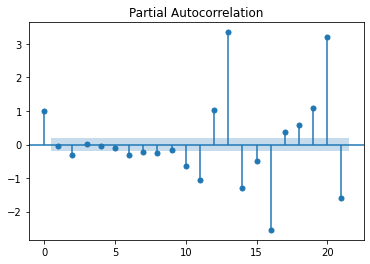

In [20]:
plot_acf(season_diff_1)
plot_pacf(season_diff_1)
plt.show()

- 1차 차분 후 자기상관계수 경향성 없어짐

(3) 다양한 적용 후 AIC값이 최소가 되는 파라미터 선정

In [21]:
import itertools

p=d=q=range(0,2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p,d,q))]

print(pdq)
print(seasonal_pdq)

[(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)]
[(0, 0, 0, 12), (0, 0, 1, 12), (0, 1, 0, 12), (0, 1, 1, 12), (1, 0, 0, 12), (1, 0, 1, 12), (1, 1, 0, 12), (1, 1, 1, 12)]


In [22]:
y=df.ridership

In [23]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y, order=param, seasonal_order=param_seasonal, enforce_stationarity=False, 
                                           enforce_invertibility=False)
            result=mod.fit()
            print('ARIMA{}X{}12 - AIC:{}'.format(param, param_seasonal, result.aic))
        
        except:
            continue

ARIMA(0, 0, 0)X(0, 0, 0, 12)12 - AIC:1916.6020925308567
ARIMA(0, 0, 0)X(0, 0, 1, 12)12 - AIC:1617.0047326978447
ARIMA(0, 0, 0)X(0, 1, 0, 12)12 - AIC:1276.4294067845128
ARIMA(0, 0, 0)X(0, 1, 1, 12)12 - AIC:1125.2265194713802
ARIMA(0, 0, 0)X(1, 0, 0, 12)12 - AIC:1260.8988169078123
ARIMA(0, 0, 0)X(1, 0, 1, 12)12 - AIC:1249.981762868111
ARIMA(0, 0, 0)X(1, 1, 0, 12)12 - AIC:1133.5713080385915
ARIMA(0, 0, 0)X(1, 1, 1, 12)12 - AIC:1084.5340910235045
ARIMA(0, 0, 1)X(0, 0, 0, 12)12 - AIC:1757.6161400877186
ARIMA(0, 0, 1)X(0, 0, 1, 12)12 - AIC:1476.0539125636558
ARIMA(0, 0, 1)X(0, 1, 0, 12)12 - AIC:1159.3965428811073
ARIMA(0, 0, 1)X(0, 1, 1, 12)12 - AIC:1025.2716005589673
ARIMA(0, 0, 1)X(1, 0, 0, 12)12 - AIC:1162.9913457622622
ARIMA(0, 0, 1)X(1, 0, 1, 12)12 - AIC:1141.7463770605539
ARIMA(0, 0, 1)X(1, 1, 0, 12)12 - AIC:1045.9862430714734
ARIMA(0, 0, 1)X(1, 1, 1, 12)12 - AIC:993.7833552323312
ARIMA(0, 1, 0)X(0, 0, 0, 12)12 - AIC:1226.3255871329823
ARIMA(0, 1, 0)X(0, 0, 1, 12)12 - AIC:1061.14400976

: 최저 AIC값 877값을 가지는 ARIMA(0, 1, 0)X(0, 1, 1, 12) 매개변수 선정

## 4. 제시한 모델의 잔차와 잡음에 대해 시각화하고 분석

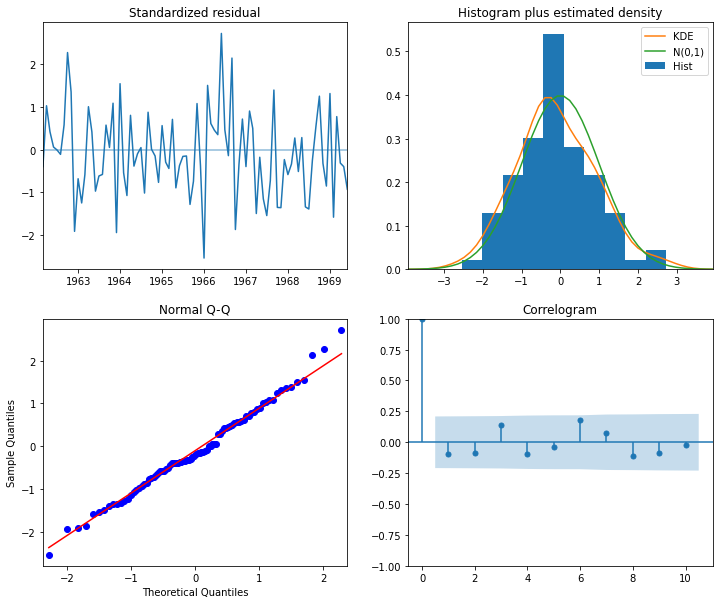

In [26]:
model = sm.tsa.statespace.SARIMAX(y, order = (0,1,0), seasonal_order = (0,1,1,12), enforce_stationarity = False, 
                                 enforce_invertibility=False)

result=model.fit()
result.plot_diagnostics(figsize=(12,10))
plt.show()

- QQ plot 에서 선형성이 두드러지며, KDE, N(0,1)이 정규분포를 따름. 
  평균화된 잔차또한 어떠한 경향성도 보이지 않아 white noise로 보임

## 5. 추후 버스 이용 승객수를 예측하시오

In [27]:
df.tail()

,ridership
Month,
1969-02-01,1425
1969-03-01,1419
1969-04-01,1432
1969-05-01,1394
1969-06-01,1327


(1) dynamic forecase 

In [31]:
pred = result.get_prediction(start=pd.to_datetime('1968-06-01'), dynamic=False)
pred_ci = pred.conf_int()
pred_forecast = result.get_prediction(end=result.nobs+20)

In [32]:
pred_ci

,lower ridership,upper ridership
1968-06-01,1314.874753,1454.749352
1968-07-01,1237.667833,1377.542432
1968-08-01,1153.022056,1292.896654
1968-09-01,1236.560449,1376.435048
1968-10-01,1302.392938,1442.267536
1968-11-01,1358.567786,1498.442385
1968-12-01,1289.489175,1429.363773
1969-01-01,1344.191323,1484.065895
1969-02-01,1411.519376,1551.184582
1969-03-01,1321.617380,1461.282586


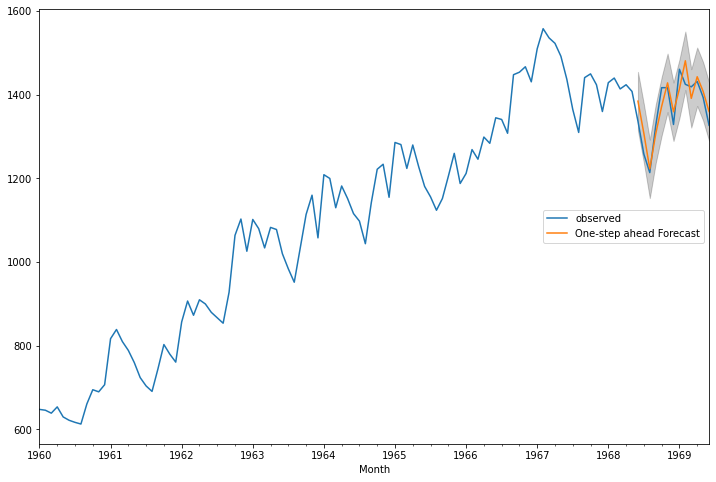

In [33]:
ax = df.ridership.plot(label='observed', figsize=(12,8))

pred.predicted_mean.plot(
    ax=ax,
    label='One-step ahead Forecast',
    )

ax.fill_between(
    pred_ci.index, 
    pred_ci['lower ridership'],
    pred_ci['upper ridership'],
    color='k',
    alpha=0.2)

plt.legend(loc=5)

In [36]:
y_forecasted = pred.predicted_mean
y_truth = y['1968-06-01':]

mse = ((y_forecasted - y_truth)**2).mean()
print(mse)

1216.2843265416152
